In [2]:
from hydra import initialize, compose

with initialize(config_path="../run/conf", version_base=None):
    cfg = compose("search", overrides=["how=group_by_day", "exp=exp008_0", "split=stratify_fold_0"])
cfg.how

'group_by_day'

In [3]:
import sys, os
sys.path.append(os.pardir)

In [4]:
from pathlib import Path
import numpy as np
import polars as pl
import os

In [5]:
Path(cfg.dir.processed_dir)
train_df = pl.read_parquet(Path(cfg.dir.data_dir) / "train_series.parquet")

In [6]:
train_df = pl.read_parquet(Path(cfg.dir.data_dir) / "train_series.parquet")
valid_df = train_df.filter(pl.col("series_id").is_in(cfg.split.valid_series_ids))
valid_df = valid_df.with_columns(
            pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
        )

event_df = pl.read_csv(Path(cfg.dir.data_dir) / "train_events.csv").drop_nulls()
valid_event_df = event_df.filter(pl.col("series_id").is_in(cfg.split.valid_series_ids))
distance = cfg.post_process.distance


exp_dir = Path(os.path.join(cfg.base_dir, cfg.exp, "single"))

keys = np.load(exp_dir / "keys.npy")
labels = np.load(exp_dir / "labels.npy")
preds = np.load(exp_dir / "preds.npy")

preds = preds[:, :, [1, 2]]

In [7]:
# valid の各ステップに予測結果を付与
count_df = valid_df.get_column("series_id").value_counts()
series2numsteps_dict = dict(count_df.select("series_id","counts").iter_rows())

# 順序を保ったままseries_idを取得
all_series_ids = valid_df.get_column("series_id").to_numpy()
_, idx = np.unique(all_series_ids, return_index=True)
unique_series_ids = all_series_ids[np.sort(idx)]

key_series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))

preds_list = []
for series_id in unique_series_ids:
    series_idx = np.where(key_series_ids == series_id)[0]
    this_series_preds = preds[series_idx].reshape(-1, 2)
    this_series_preds = this_series_preds[:series2numsteps_dict[series_id], :]
    preds_list.append(this_series_preds)

preds_all = np.concatenate(preds_list, axis=0)
preds_all.shape

valid_preds_df = valid_df.with_columns(pl.Series(name="prediction_onset", values=preds_all[:,0]),
                     pl.Series(name="prediction_wakeup", values=preds_all[:,1]))

In [8]:
valid_preds_df.head(5)

series_id,step,timestamp,anglez,enmo,prediction_onset,prediction_wakeup
str,u32,"datetime[μs, UTC]",f32,f32,f32,f32
"""0402a003dae9""",0,2018-12-18 17:45:00 UTC,-77.314903,0.0868,0.002726,0.0078125
"""0402a003dae9""",1,2018-12-18 17:45:05 UTC,-52.1838,0.0434,0.002104,0.006104
"""0402a003dae9""",2,2018-12-18 17:45:10 UTC,-53.218601,0.0541,0.000863,0.002686
"""0402a003dae9""",3,2018-12-18 17:45:15 UTC,-51.541698,0.0612,0.000264,0.000946
"""0402a003dae9""",4,2018-12-18 17:45:20 UTC,-24.6373,0.0591,0.000308,0.000881


In [9]:
def make_submission(preds_df: pl.DataFrame) -> pl.DataFrame:
    event_dfs = [
        preds_df.with_columns(pl.lit(event).alias("event"), pl.col("timestamp").dt.date().alias("date"))
        .group_by(["series_id", "date"])
        .agg(pl.all().sort_by(f"prediction_{event}").last())
        .rename({f"prediction_{event}": "score"})
        .select(["series_id", "step", "event", "score"])
        for event in ["onset", "wakeup"]
    ]
    submission_df = (
        pl.concat(event_dfs)
        .sort(["series_id", "step"])
        .with_columns(pl.arange(0, pl.count()).alias("row_id"))
        .select(["row_id", "series_id", "step", "event", "score"])
    )
    return submission_df


In [ ]:
submission_df = make_submission(valid_preds_df)
submission_df = submission_df.to_pandas()
submission_df.head()

In [ ]:
valid_event_df.head()

## find_peaks

In [11]:
from src.utils.post_process import post_process_for_seg

find_peaks_df = post_process_for_seg(
                keys=keys,
                preds=preds,
                score_th=0.02,
                distance=20,
            ).to_pandas()

find_peaks_df.head(10)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,row_id,series_id,step,event,score
0,0,0402a003dae9,2616,onset,0.299805
1,1,0402a003dae9,5016,onset,0.020264
2,2,0402a003dae9,5316,onset,0.022797
3,3,0402a003dae9,5377,onset,0.024536
4,4,0402a003dae9,5467,onset,0.933594
5,5,0402a003dae9,5580,onset,0.030060
6,6,0402a003dae9,5705,onset,0.028824
7,7,0402a003dae9,5740,onset,0.067017
8,8,0402a003dae9,5934,onset,0.444824
9,9,0402a003dae9,6211,onset,0.350098


## vis

In [12]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_series_with_events(series_id, train_series, train_events, pred_events, pred_linewidth=0.5):
    # Filter the DataFrame based on the series_id
    sample_serie = train_series[train_series["series_id"] == series_id].reset_index(drop=True)

    # Filter event data based on the series_id
    sample_events = train_events[train_events["series_id"] == series_id]
    sample_time_pairs = sample_events.groupby('night')['timestamp'].apply(lambda x: tuple(x.head(2)))

    # Filter event data based on the series_id
    sample_pred_events = pred_events[pred_events["series_id"] == series_id]
    sample_pred_onset_id = sample_pred_events.loc[sample_pred_events["event"] == "onset", "step"].dropna()
    sample_pred_onset = sample_serie.loc[sample_pred_onset_id, "timestamp"]
    sample_pred_wakeup_id = sample_pred_events.loc[sample_pred_events["event"] == "wakeup", "step"].dropna()   
    sample_pred_wakeup = sample_serie.loc[sample_pred_wakeup_id, "timestamp"] 
    
    # Helper function to plot data and events
    def plot_data_and_events(data, ylabel):
        plt.figure(figsize=(20, 5))
        plt.plot(sample_serie["timestamp"], sample_serie[data], label=data, linewidth=1)

        for x in sample_time_pairs:
            if len(x)==2:
                l, r = x
            if (l is not None) and (r is not None):
                plt.axvspan(l, r, color="gray", alpha=0.4)
        for onset in sample_pred_onset:
            plt.axvline(x=onset, color="m", linestyle="dotted", label="onset", linewidth=pred_linewidth)

        for wakeup in sample_pred_wakeup:
            plt.axvline(x=wakeup, color="c", linestyle="dotted", label="wakeup", linewidth=pred_linewidth)

        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels, new_handles = [], []
        for handle, label in zip(handles, labels):
            if label not in new_labels:
                new_handles.append(handle)
                new_labels.append(label)

        plt.legend(new_handles, new_labels)
        plt.xlabel("Timestamp")
        plt.ylabel(ylabel)
        plt.title(f"{ylabel} over Time with Event Flags - " + series_id)
        plt.show()

    # Plot enmo and anglez
    plot_data_and_events("enmo", "ENMO Value")
    plot_data_and_events("anglez", "anglez Value")


In [13]:
val_series = valid_df.to_pandas()
val_events = valid_event_df.with_columns(
            pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
        ).to_pandas()

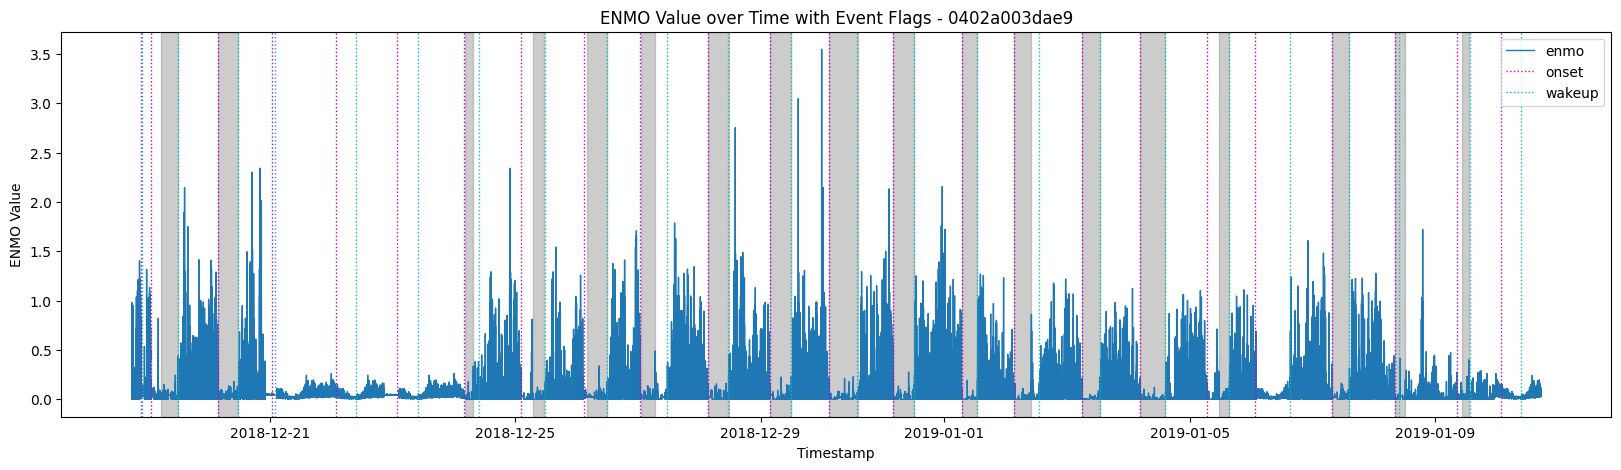

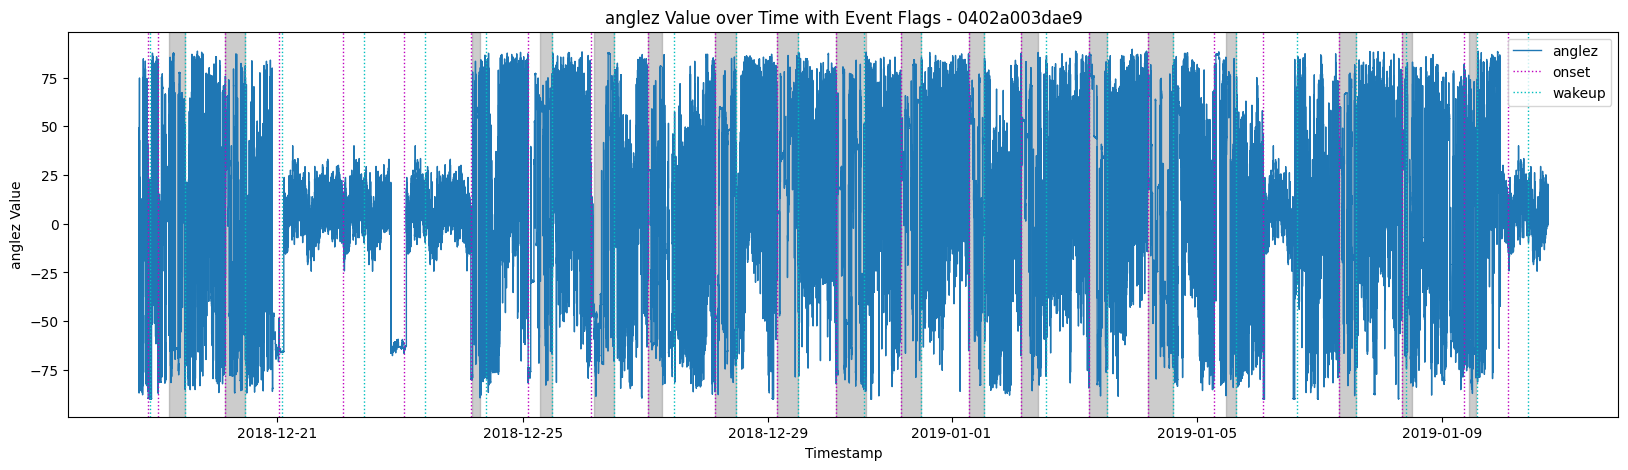

In [14]:
plot_series_with_events("0402a003dae9", val_series, val_events, submission_df, pred_linewidth=1.0)

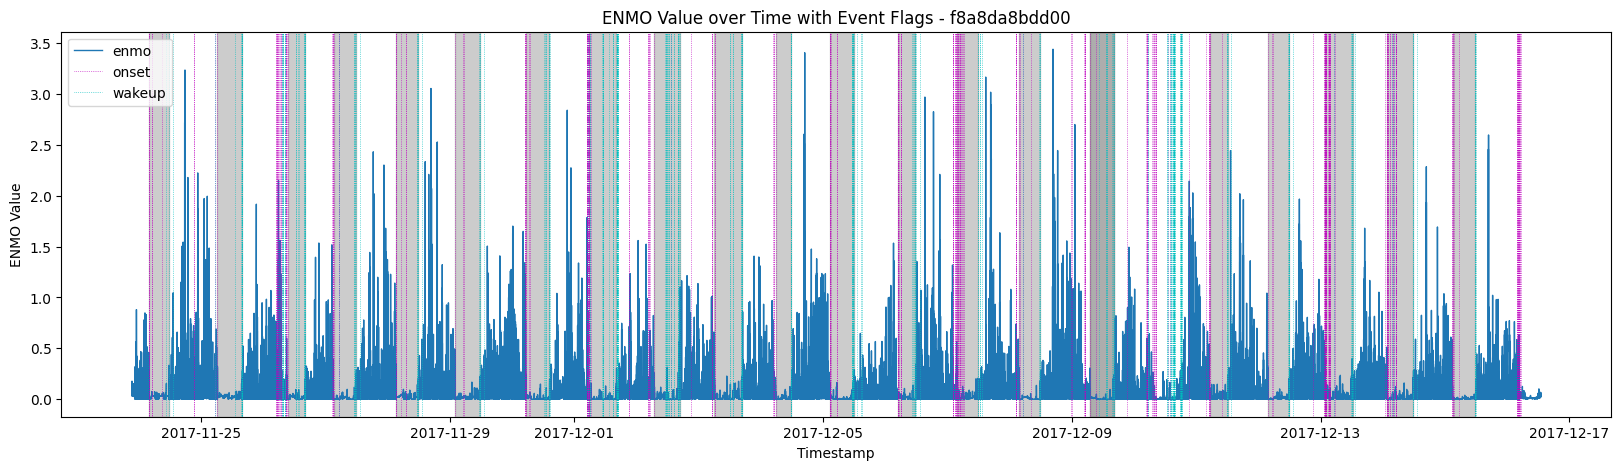

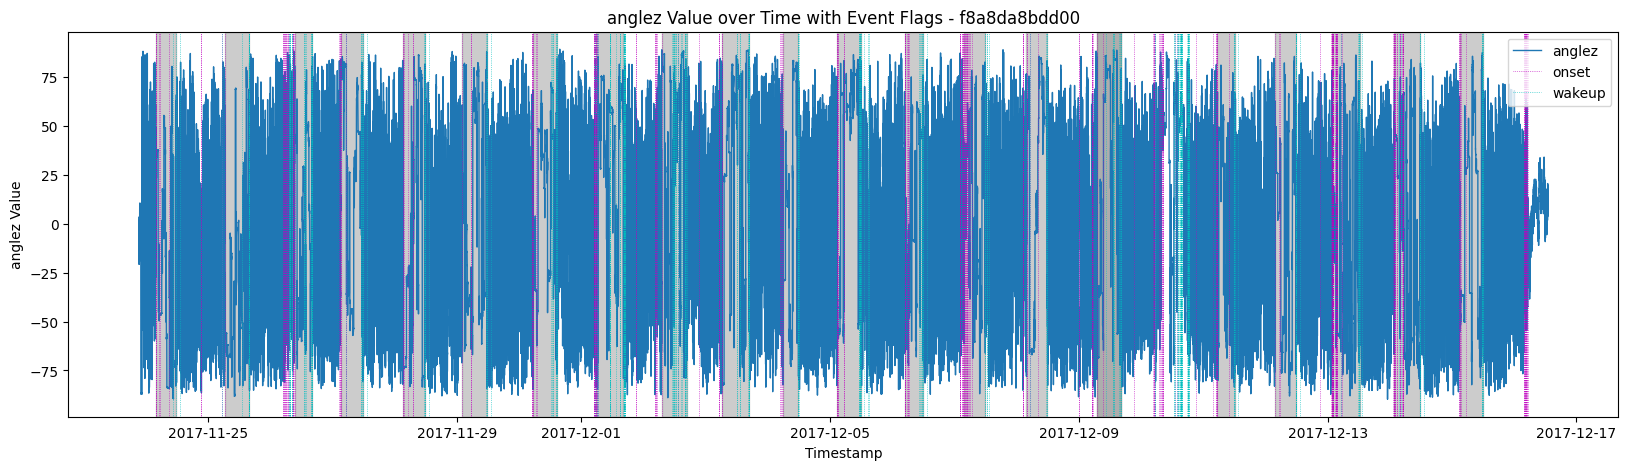

In [15]:
plot_series_with_events("f8a8da8bdd00", val_series, val_events, find_peaks_df)

## 確率を付与

In [16]:
val_series = valid_preds_df.to_pandas()
val_events = valid_event_df.with_columns(
            pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
        ).to_pandas()

In [17]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_series_prob_with_events(series_id, train_series, train_events, pred_events, pred_linewidth=0.5):
    # Filter the DataFrame based on the series_id
    sample_serie = train_series[train_series["series_id"] == series_id].reset_index(drop=True)

    # Filter event data based on the series_id
    sample_events = train_events[train_events["series_id"] == series_id]
    sample_time_pairs = sample_events.groupby('night')['timestamp'].apply(lambda x: tuple(x.head(2)))

    # Filter event data based on the series_id
    sample_pred_events = pred_events[pred_events["series_id"] == series_id]
    sample_pred_onset_id = sample_pred_events.loc[sample_pred_events["event"] == "onset", "step"].dropna()
    sample_pred_onset = sample_serie.loc[sample_pred_onset_id, "timestamp"]
    sample_pred_wakeup_id = sample_pred_events.loc[sample_pred_events["event"] == "wakeup", "step"].dropna()   
    sample_pred_wakeup = sample_serie.loc[sample_pred_wakeup_id, "timestamp"] 
    
    # Helper function to plot data and events
    def plot_data_and_events(data, ylabel):
        plt.figure(figsize=(20, 5))
        plt.plot(sample_serie["timestamp"], sample_serie[data], label=data, linewidth=1)
        plt.plot(sample_serie["timestamp"], sample_serie["prediction_onset"], color='g', label="onset_prob", linewidth=1)
        plt.plot(sample_serie["timestamp"], sample_serie["prediction_wakeup"], color='r', label="wakeup_prob", linewidth=1)

        for x in sample_time_pairs:
            if len(x)==2:
                l, r = x
            if (l is not None) and (r is not None):
                plt.axvspan(l, r, color="gray", alpha=0.4)
        for onset in sample_pred_onset:
            plt.axvline(x=onset, color="m", linestyle="--", label="onset", linewidth=pred_linewidth)

        for wakeup in sample_pred_wakeup:
            plt.axvline(x=wakeup, color="c", linestyle="--", label="wakeup", linewidth=pred_linewidth)

        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels, new_handles = [], []
        for handle, label in zip(handles, labels):
            if label not in new_labels:
                new_handles.append(handle)
                new_labels.append(label)

        plt.legend(new_handles, new_labels)
        plt.xlabel("Timestamp")
        plt.ylabel(ylabel)
        plt.title(f"{ylabel} over Time with Event Flags - " + series_id)
        plt.show()

    # Plot enmo and anglez
    plot_data_and_events("enmo", "ENMO Value")
    #plot_data_and_events("anglez", "anglez Value")


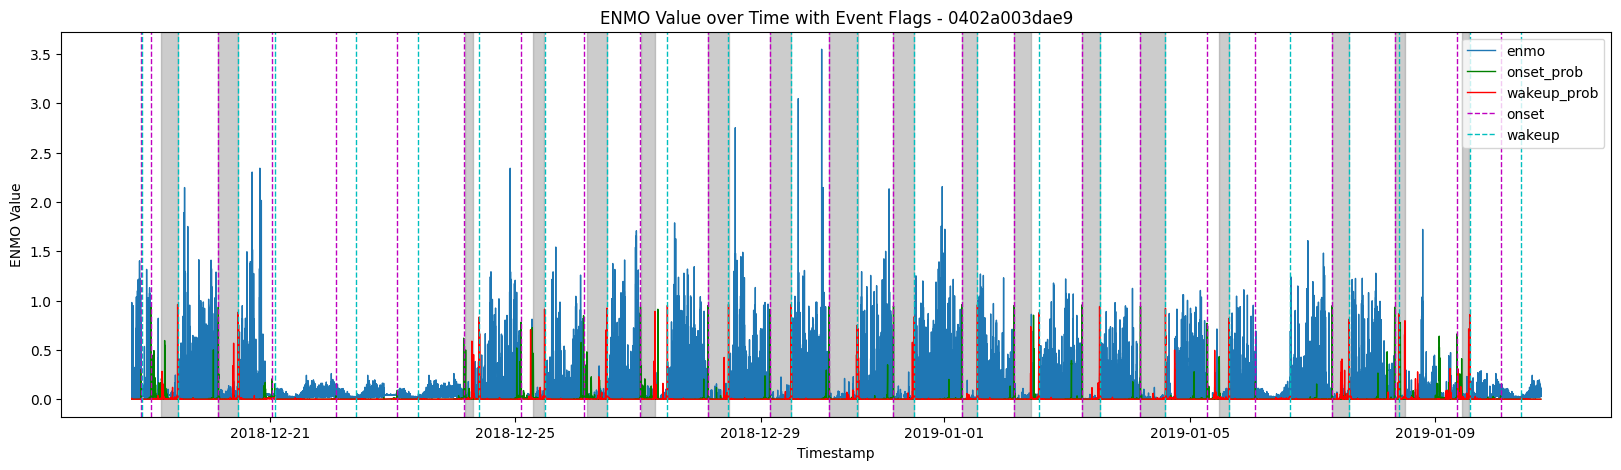

In [18]:
plot_series_prob_with_events("0402a003dae9", val_series, val_events, submission_df, pred_linewidth=1.0)

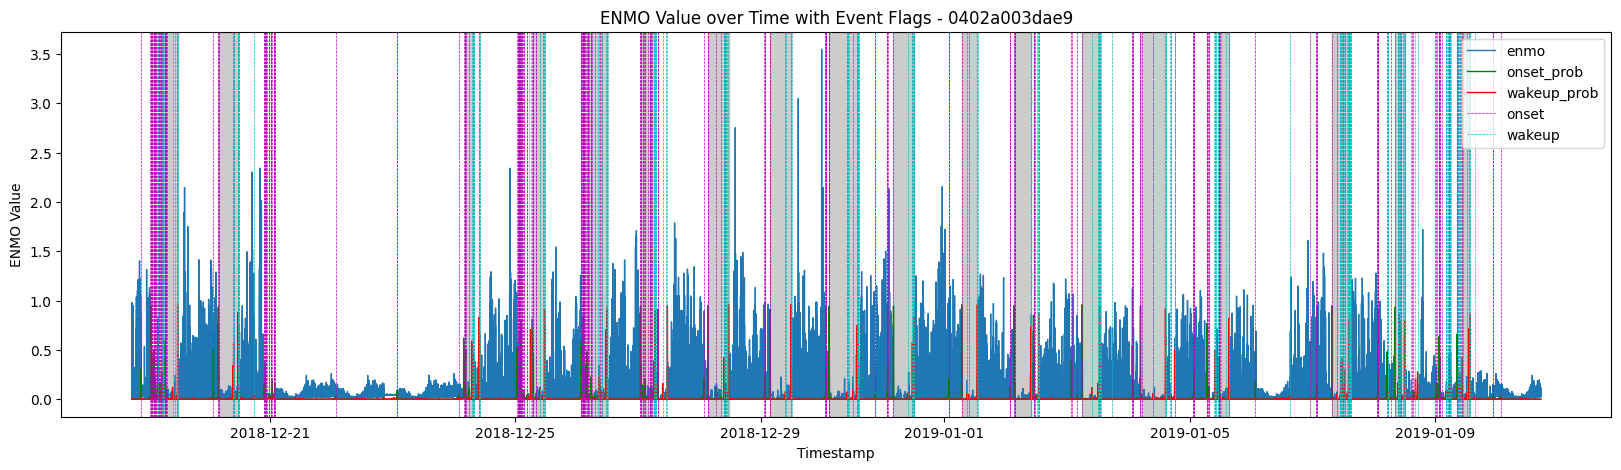

In [19]:
plot_series_prob_with_events("0402a003dae9", val_series, val_events, find_peaks_df)